In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    classification_report,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras

from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

In [2]:
PATH = "/app/_data/"
BATCH_SIZE = 32
SEED = 1488
IMAGE_SIZE = (380, 380)
NUM_CLASSES = 6
INPUT_SHAPE = (380, 380, 3)
TRAIN_IMG_PATH = "/app/_data/380/"
TEST_IMG_PATH = "/app/_data/test_images/"


In [3]:
labels = pd.read_csv(PATH + "train_labels.csv")

In [4]:
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [5]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [6]:
labels.head(1)

image   labels  complex  frog_eye_leaf_spot  healthy  \
0  800113bb65efe69e.jpg  healthy        0                   0        1   

   powdery_mildew  rust  scab  
0               0     0     0

In [7]:
feature_columns = labels.columns[2:].tolist()
feature_columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [8]:
feature_columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [9]:
labels_2020 = pd.read_csv(PATH+'train_20.csv')
labels_2020.sample()

image_id  healthy  multiple_diseases  rust  scab
1180  Train_1180        1                  0     0     0

In [10]:
labels_2020['image_id'] = labels_2020['image_id']+'.jpg'

In [11]:
all_wrong = pd.read_csv(PATH+"all_wrong_7mod.csv", index_col=[0])
all_wrong.sample()

0
0  928524ea9778cb9e.jpg

In [12]:
all_wrong.columns = ['image']
all_wrong = all_wrong.merge(labels, on='image', how='left')
all_wrong.head()

image                           labels  complex  \
0  928524ea9778cb9e.jpg                          complex        1   
1  f5cbd285dd1a1e10.jpg  scab frog_eye_leaf_spot complex        1   
2  fb9fd1486816f2a0.jpg          scab frog_eye_leaf_spot        0   
3  bd25252ff090b9e8.jpg                          complex        1   
4  8d784bc9270bb2ab.jpg  scab frog_eye_leaf_spot complex        1   

   frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                   0        0               0     0     0  
1                   1        0               0     0     1  
2                   1        0               0     0     1  
3                   0        0               0     0     0  
4                   1        0               0     0     1

In [13]:
labels_2020.columns = ['image', 'healthy', 'complex', 'rust', 'scab']
feature_columns_20 = labels_2020.columns[1:]

In [14]:
for i in labels_2020.index:
    labels_2020.loc[i, 'labels_20'] = ''.join(list(map(lambda x, y: x*y, labels_2020.loc[i,feature_columns_20].values, feature_columns_20)))

In [15]:
labels_21_20 = pd.concat([labels, labels_2020], axis=0,
    join='outer',
    ignore_index=True)

In [16]:
labels_21_20[feature_columns] = labels_21_20[feature_columns].fillna(0).astype('int')

In [17]:
labels_21_20['labels'] = labels_21_20['labels'].fillna(labels_21_20['labels_20'])
labels_21_20 = labels_21_20.drop('labels_20', axis=1)
labels_21_20.head(2)

image                           labels  complex  \
0  800113bb65efe69e.jpg                          healthy        0   
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex        1   

   frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                   0        1               0     0     0  
1                   1        0               0     0     1

In [18]:
labels_long = pd.concat([labels_21_20, all_wrong, all_wrong, all_wrong, all_wrong], axis=0,
    join='outer',
    ignore_index=True)

In [19]:
labels_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23105 entries, 0 to 23104
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   image               23105 non-null  object
 1   labels              23105 non-null  object
 2   complex             23105 non-null  int64 
 3   frog_eye_leaf_spot  23105 non-null  int64 
 4   healthy             23105 non-null  int64 
 5   powdery_mildew      23105 non-null  int64 
 6   rust                23105 non-null  int64 
 7   scab                23105 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.4+ MB


In [20]:
labels_long['labels'].value_counts()

scab                               5461
healthy                            5148
frog_eye_leaf_spot                 3191
rust                               2462
complex                            2412
scab frog_eye_leaf_spot            1354
powdery_mildew                     1232
scab frog_eye_leaf_spot complex     656
rust frog_eye_leaf_spot             394
frog_eye_leaf_spot complex          369
powdery_mildew complex              235
rust complex                        191
Name: labels, dtype: int64

In [21]:
labels_long_1 = labels_long.copy()

In [22]:
for col in ['powdery_mildew',
 'scab frog_eye_leaf_spot',
 'scab frog_eye_leaf_spot complex',
 'frog_eye_leaf_spot complex',
 'rust frog_eye_leaf_spot',
 'powdery_mildew complex',
 'rust complex']:
    n_count = labels_long['labels'].value_counts()[col]
    samp = labels[labels['labels'] == col].sample(n=2000-n_count,
    replace=True,
    random_state=SEED,
    axis=None,
)
    labels_long_1 = pd.concat([labels_long_1, samp], axis=0,
    join='outer',
    ignore_index=True)

In [23]:
labels_long_1 = labels_long_1.sample(frac=1, random_state = SEED).reset_index(drop = True)

In [24]:
labels_long_1['labels'].value_counts()

scab                               5461
healthy                            5148
frog_eye_leaf_spot                 3191
rust                               2462
complex                            2412
powdery_mildew                     2000
rust complex                       2000
scab frog_eye_leaf_spot complex    2000
rust frog_eye_leaf_spot            2000
frog_eye_leaf_spot complex         2000
scab frog_eye_leaf_spot            2000
powdery_mildew complex             2000
Name: labels, dtype: int64

### StratifiedShuffleSplit

In [25]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)

for train_index, valid_index in sss.split(labels["image"], labels['labels']):
    train, valid = labels.loc[train_index], labels.loc[valid_index]

In [26]:
def pred_to_labels(pred, thresh=0.5, labels=feature_columns):

    pred = [labels[i] for i in range(len(labels)) if pred[i] > thresh]
    pred = ' '.join(pred)
    return pred

In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical", seed=SEED
        ),
        keras.layers.experimental.preprocessing.RandomRotation(0.5, seed=SEED),
        keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1, seed=SEED),
        keras.layers.experimental.preprocessing.RandomContrast(factor=0.3, seed=SEED),
        keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.1, width_factor=0.1, seed=SEED
        ),
    ]
)


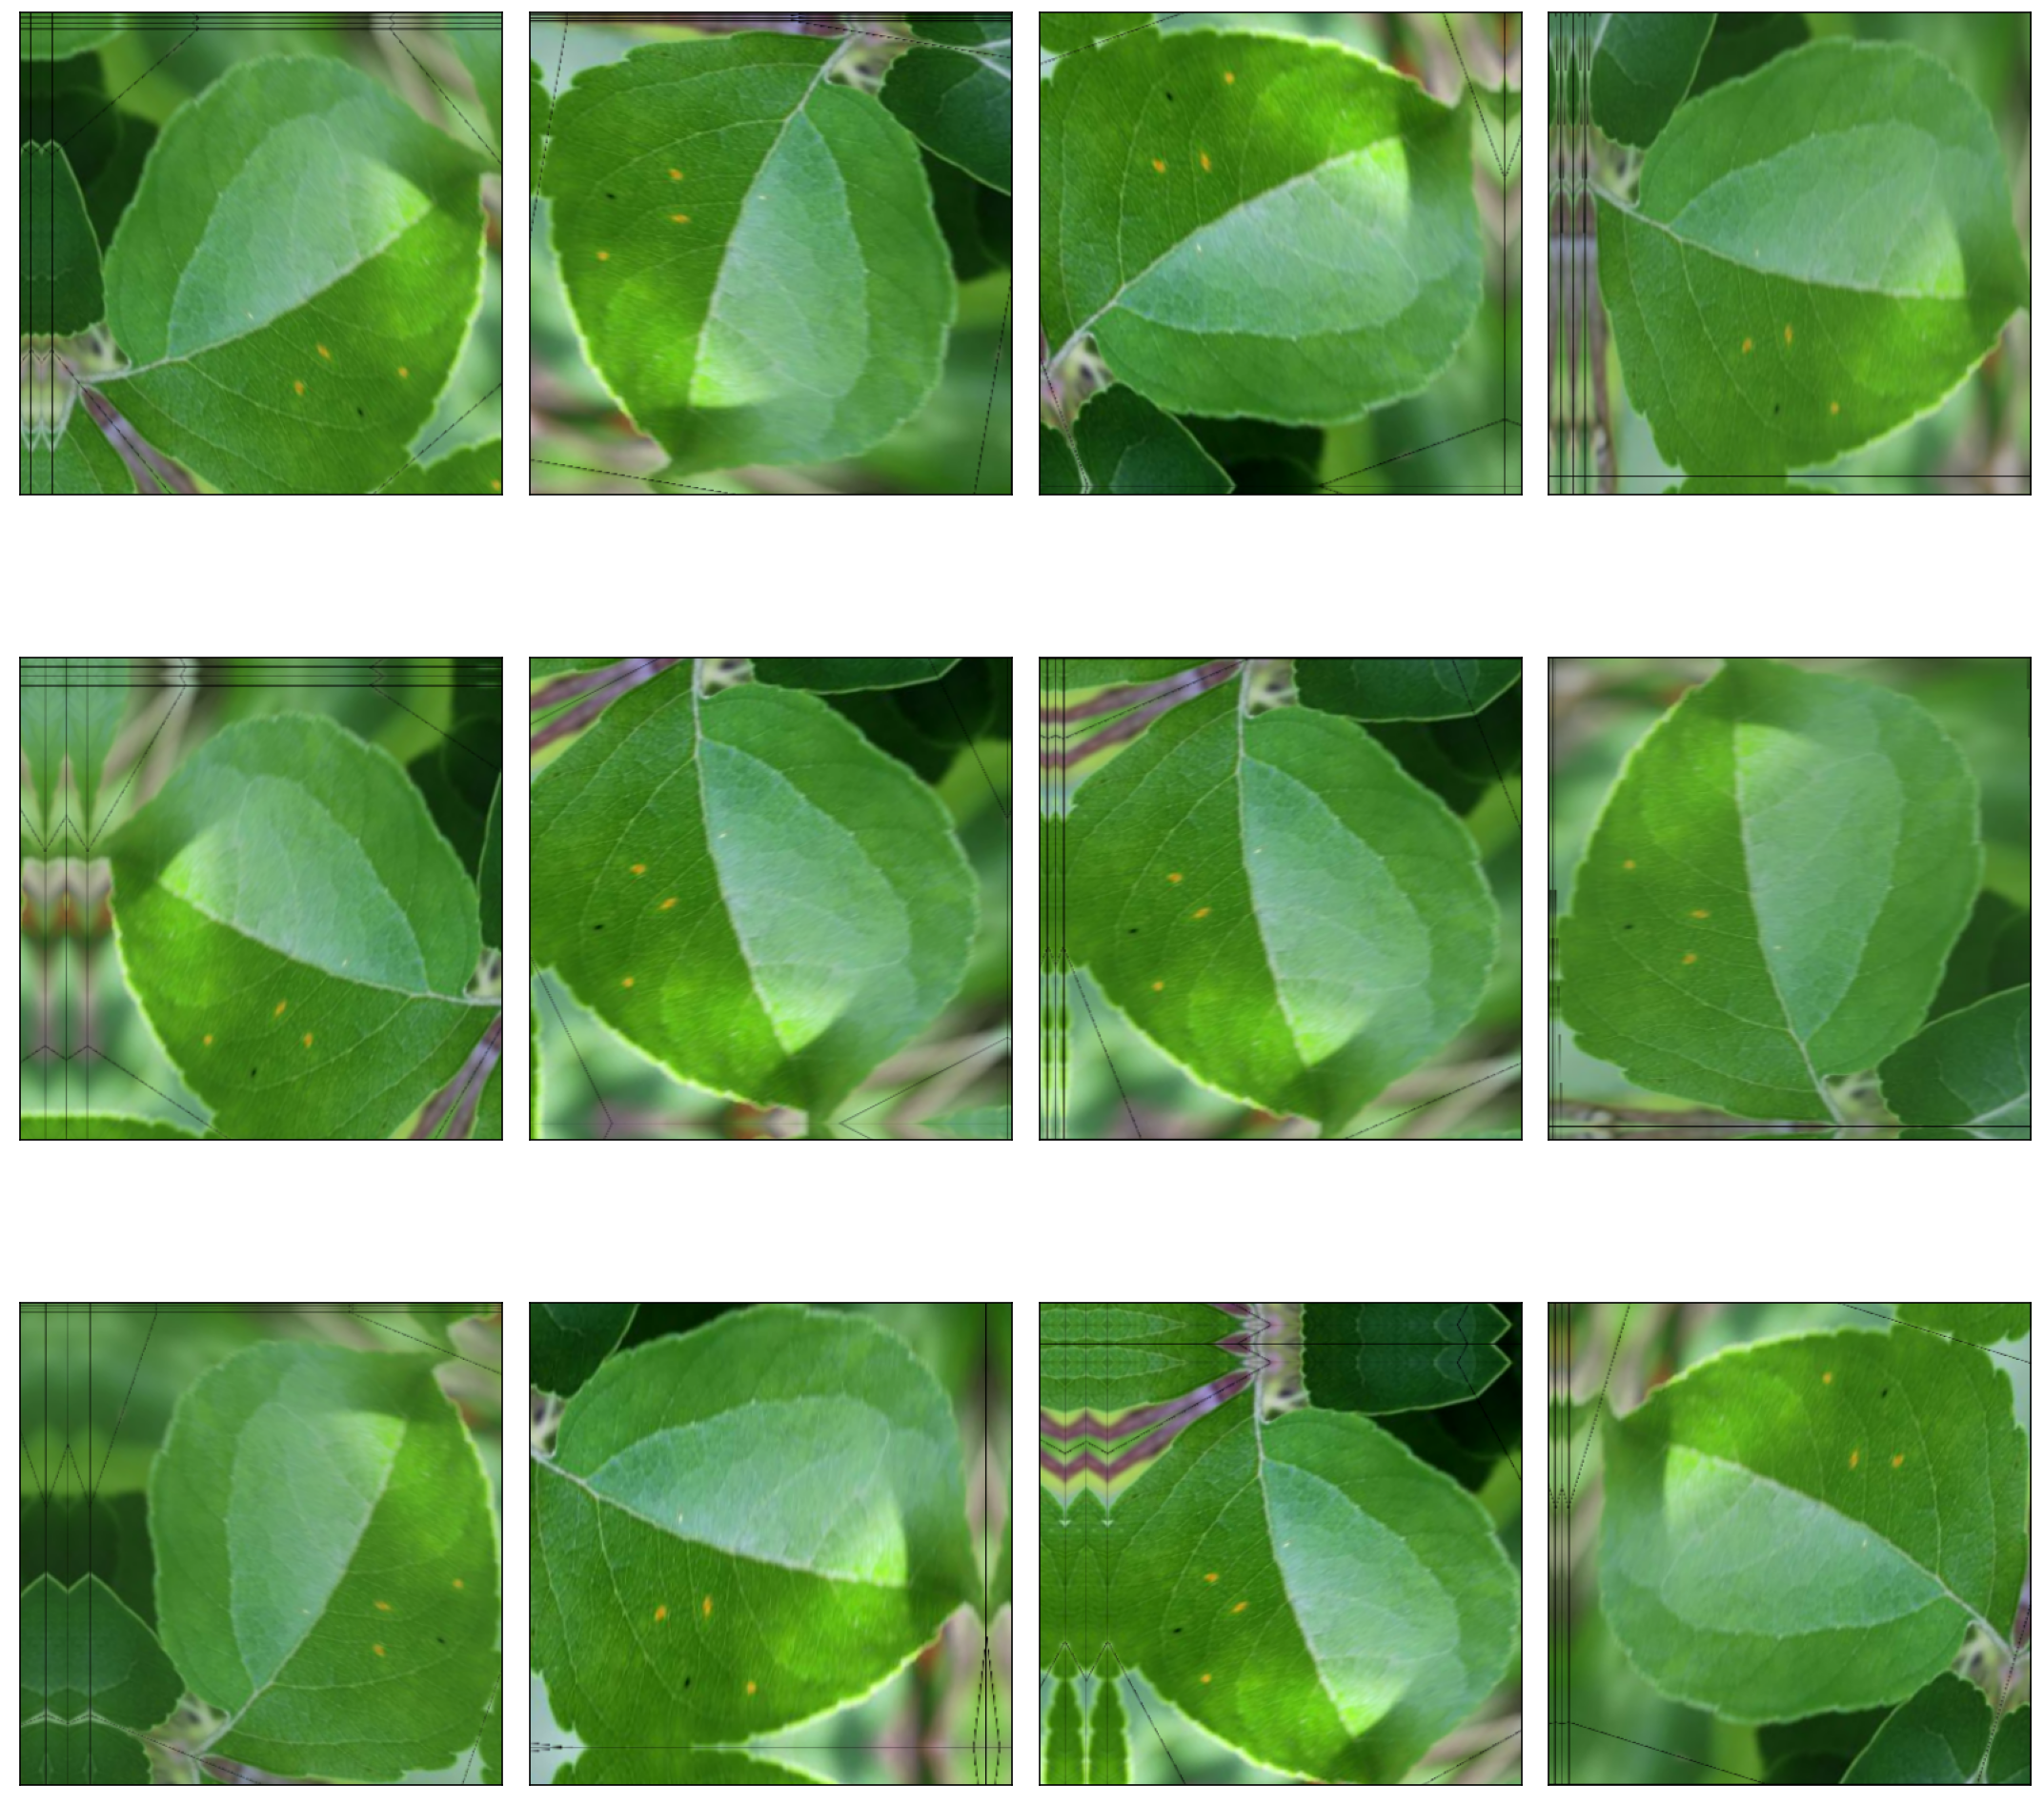

In [51]:
plt.figure(figsize = (15,15))
for i in range(12):
    img = parse_image2('bacf4b8c6a3c3131.jpg')
    img = tf.expand_dims(img,axis = 0)
    img = data_augmentation(img)
    img = tf.reshape(img, INPUT_SHAPE)
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show();

In [30]:
labels.sample()

image labels  complex  frog_eye_leaf_spot  healthy  \
8224  bacf4b8c6a3c3131.jpg   rust        0                   0        0   

      powdery_mildew  rust  scab  
8224               0     1     0

In [46]:
# def write_np(file_path):
#     img = tf.io.read_file(TRAIN_IMG_PATH + file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(
#         img,
#         IMAGE_SIZE,
#     )
#     img = tf.image.convert_image_dtype(img, tf.uint8)
#     img = Image.fromarray(np.array(img))
#     img.save(PATH + '380/'+file_path)
#     return img
#     np.save(PATH + 'cache/'+file_path[:-4], img)
# labels['image'].apply(write_np)

In [28]:
# from 380 uint8
def parse_image2(file_path):
    img = tf.io.read_file(PATH+'cropped_all_v1/'+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [45]:
# v1 from orig
def parse_image(file_path):
    img = tf.io.read_file(TRAIN_IMG_PATH+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(
        img,
        IMAGE_SIZE,
    )
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img


In [46]:
def prepare_dataset(df, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df["image"].values, df[feature_columns].astype('uint8').values)
    )
    dataset = dataset.map(lambda x, y: (parse_image2(x), y))
    dataset = dataset.batch(BATCH_SIZE)

    if augmentation:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )
    dataset = dataset.repeat().prefetch(buffer_size=AUTOTUNE)
    return dataset

In [47]:
ds_train = prepare_dataset(train, augmentation = True)
ds_valid = prepare_dataset(valid)

In [48]:
for a, b in ds_valid.take(1):
    print(a[0].dtype, b.dtype)
    print(a[0].shape, b.shape)


<dtype: 'uint8'> <dtype: 'uint8'>
(380, 380, 3) (32, 6)


In [49]:
def parse_test_image(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(
        img,
        IMAGE_SIZE,
    )
    img = tf.image.convert_image_dtype(img, tf.uint8)
    return img


def predict_new(path, model):
    img = parse_test_image(path)
    img = tf.expand_dims(img,axis = 0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [50]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

In [51]:
def scheduler(epoch, lr):
    if epoch < 5:
        return 0.01
    elif 5 <= epoch <10:
        return 0.001
    elif 10 <= epoch <50:
        return 0.0005
    else:
        return 0.0001

In [52]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, restore_best_weights=True, verbose=0, mode='min',
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/eff4_ns_3.h5",
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.LearningRateScheduler(schedule = scheduler, verbose=1)
]

In [53]:
# base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
# base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)

In [57]:
inputs = keras.Input(shape=INPUT_SHAPE)
base_model = keras.applications.EfficientNetB4(weights=None, include_top=False)
base_model.load_weights('/app/_data/models/efficientnet-b4_noisy-student_notop.h5', by_name=True, skip_mismatch = True)
x = base_model(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [58]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=['acc',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
    ],
)

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    steps_per_epoch=(train.shape[0]*0.8)//BATCH_SIZE, 
    validation_steps= (valid.shape[0]*0.2)//BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
735/735 [==============================] - 484s 658ms/step - loss: 0.3516 - acc: 0.5126 - recall_2: 0.5495 - precision_2: 0.7053 - f1_score: 0.5739 - val_loss: 0.6250 - val_acc: 0.4141 - val_recall_2: 0.4268 - val_precision_2: 0.5033 - val_f1_score: 0.4139

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
735/735 [==============================] - 478s 650ms/step - loss: 0.2693 - acc: 0.6053 - recall_2: 0.7070 - precision_2: 0.7816 - f1_score: 0.6704 - val_loss: 0.2671 - val_acc: 0.6016 - val_recall_2: 0.6799 - val_precision_2: 0.7739 - val_f1_score: 0.6496

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
735/735 [==============================] - 473s 644ms/step - loss: 0.2453 - acc: 0.6228 - recall_2: 0.7474 - precision_2: 0.8008 - f1_score: 0.6866 - val_loss: 0.3988 - val_acc: 0.5984 - val_recall_2: 0.7128 - val_precision_2: 0.6267 - val_f1_sco

In [ ]:
model.save("/app/_data/models/eff4_ns_ups1.h5")

In [28]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

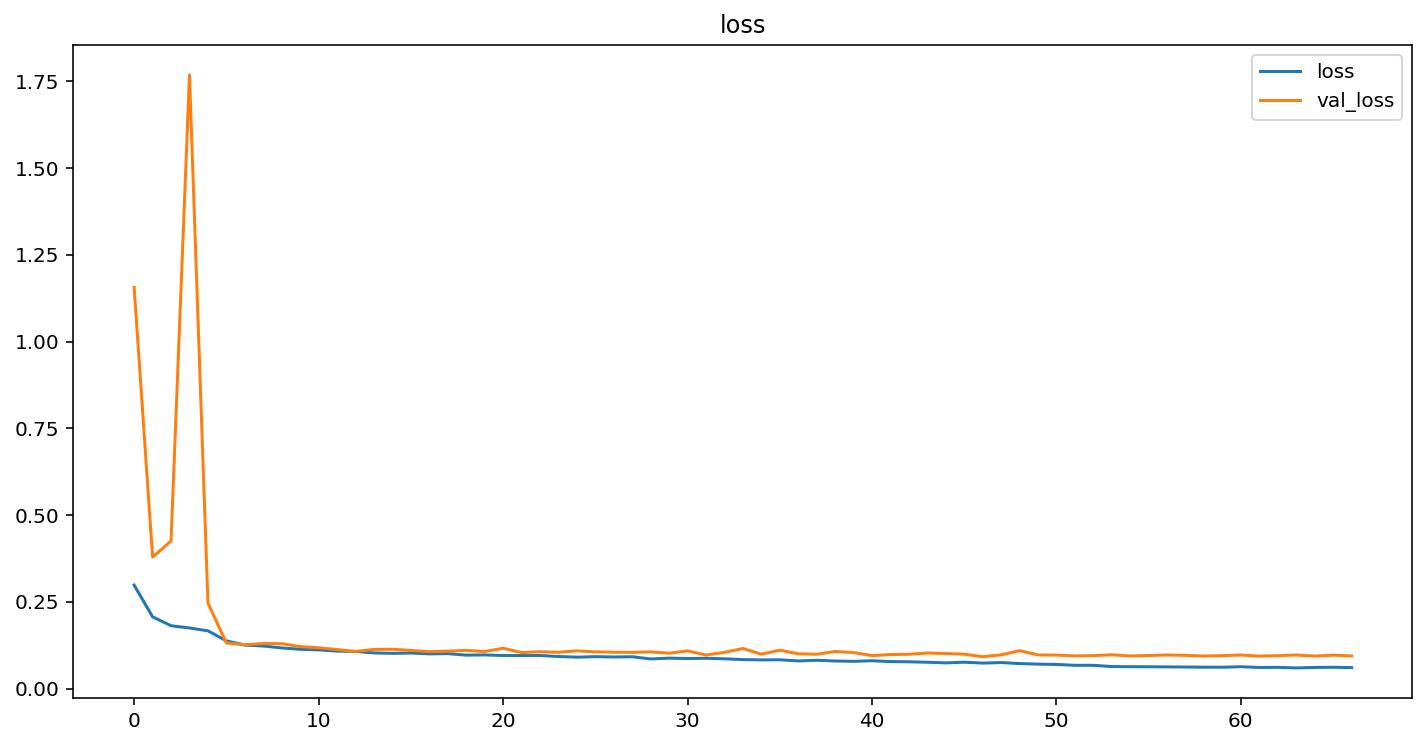

In [30]:
plot_curves(history,loss=True)

In [31]:
def parse_all(file_path):
    img = tf.io.read_file(PATH+'380/'+file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img
def predict_new(path, model):
    img = parse_all(path)
    img = tf.expand_dims(img,axis = 0)
    pred = model.predict(img)
    return pred_to_labels(pred[0])

In [32]:
df_sub = pd.DataFrame(columns=['image','labels'])
for img_name in os.listdir(PATH+'380/'):
    pred = predict_new(img_name, model)
    
    df_sub = df_sub.append( {'image': img_name, 'labels': pred}, ignore_index = True )
    
print(df_sub.head())

                  image              labels
0  bfc6d90f402f4c34.jpg             complex
1  9eb93fe282326266.jpg      powdery_mildew
2  f4cb3a8f41b413e4.jpg  frog_eye_leaf_spot
3  98322eab16bef2c1.jpg                rust
4  dad5d6250cae80b7.jpg             complex


In [33]:
df_sub = df_sub.merge(labels[['image', 'labels']], on='image', how='left', suffixes=('_pred', '_true'))

In [34]:
df_sub.to_csv('/app/sandbox/wrong_predictions/prediction_raw_7.csv')

In [35]:
df_sub[df_sub['labels_pred'] == '']['labels_true'].value_counts()

scab                               32
complex                            31
healthy                            22
rust                               14
frog_eye_leaf_spot                 13
powdery_mildew                     12
scab frog_eye_leaf_spot             7
powdery_mildew complex              3
frog_eye_leaf_spot complex          1
rust frog_eye_leaf_spot             1
rust complex                        1
scab frog_eye_leaf_spot complex     1
Name: labels_true, dtype: int64